<a href="https://colab.research.google.com/github/singhneha139222-desig/Library-Management-System-/blob/main/Copy_of_DriveMind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mohamedmaher5_vehicle_classification_path = kagglehub.dataset_download('mohamedmaher5/vehicle-classification')

print('Data source import complete.')

100%|██████████| 827M/827M [00:09<00:00, 88.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install torchmetrics

In [ ]:
#Importing Modules
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import torchmetrics
from torchmetrics import Accuracy
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from random import shuffle, seed
from pathlib import Path

#Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Printing Versions
print(f"Pytorch Version : {torch.__version__}")
print(f"Torchvision Version : {torchvision.__version__}")
print(f"Torchmetrics Version : {torchmetrics.__version__}")
print(f"Device : {device}")

Pytorch Version : 2.8.0+cu126
Torchvision Version : 0.23.0+cu126
Torchmetrics Version : 1.8.2
Device : cuda


In [ ]:
#Transform Image into Tensors
train_transform = transforms.Compose([
    transforms.Resize(size = (128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 45),
    transforms.ColorJitter(
        brightness = 0.1,
        contrast = 0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.4641, 0.4725, 0.4705],
        std = [0.3169, 0.3097, 0.3201]
    ),
    transforms.RandomErasing(
        p = 0.5,
        scale = (0.01, 0.33),
        ratio = (0.3, 3.3)
    )
])

validation_transform = transforms.Compose([
    transforms.Resize(size = (128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.4641, 0.4725, 0.4705],
        std = [0.3169, 0.3097, 0.3201]
    )
])

In [ ]:
#Reproducability
manual_seed = 5

#Vehicle Dataset
class VehicleDataset(Dataset):

    def __init__(self,
                 root : str,
                 split : str = 'train',
                 transform : torchvision.transforms = transforms.ToTensor()):

        self.root = Path(root) / "Vehicles" # Assuming "Vehicles" is the subdirectory containing the image folders
        self.transform = transform
        self.classes = [str(folder.relative_to(self.root)) for folder in self.root.iterdir()]

        self.data = []
        for folder in self.root.iterdir():
            label = self.classes.index(str(folder.relative_to(self.root)))

            for img in folder.glob("*.jpg"):
                self.data.append([img, label])

        print(f"Total number of images found: {len(self.data)}") # Debug print

        #Train and Test
        train_data = []
        validation_data = []
        test_data = []
        for label in range(len(self.classes)):
            class_images = [image for image in self.data if image[1] == label]
            shuffle(class_images)
            n_train = int(0.7 * len(class_images))
            n_val = int(0.15 * len(class_images))
            train_data += class_images[: n_train]
            validation_data += class_images[n_train: n_train + n_val]
            test_data += class_images[n_train + n_val:]

        print(f"Train data size after split: {len(train_data)}") # Debug print
        print(f"Validation data size after split: {len(validation_data)}") # Debug print
        print(f"Test data size after split: {len(test_data)}") # Debug print


        data = {'train' : train_data, 'validation' : validation_data, 'test' : test_data}
        self.data = data[split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx : int):
        image, label = self.data[idx]
        image = Image.open(image).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

#Get Each Dataset

seed(manual_seed)
train_dataset = VehicleDataset(root = mohamedmaher5_vehicle_classification_path,
                               transform = train_transform,
                               split = 'train')

seed(manual_seed)
validation_dataset = VehicleDataset(root = mohamedmaher5_vehicle_classification_path,
                               transform = validation_transform,
                               split = 'validation')

seed(manual_seed)
test_dataset = VehicleDataset(root = mohamedmaher5_vehicle_classification_path,
                               transform = validation_transform,
                               split = 'test')

Total number of images found: 5007
Train data size after split: 3502
Validation data size after split: 749
Test data size after split: 756
Total number of images found: 5007
Train data size after split: 3502
Validation data size after split: 749
Test data size after split: 756
Total number of images found: 5007
Train data size after split: 3502
Validation data size after split: 749
Test data size after split: 756


In [ ]:
"""from google.colab import drive
drive.mount('/content/drive')"""

ValueError: mount failed

In [ ]:
#Visualise
def visualise(dataset : Dataset,
              idx : int):

    img, label = dataset[idx]

    #Image is in [C, H ,W]
    img = img.permute(1, 2, 0)


    plt.title(dataset.classes[label])
    plt.imshow(img)
    plt.axis(False)

def grid_display(dataset : Dataset,
                 rows : int = 5,
                 cols : int = 5):
    #Visualising Grid
    fig = plt.figure(figsize = (11, 11))

    for i in range(1, rows * cols + 1):
        fig.add_subplot(rows, cols, i)
        idx = torch.randint(0, len(dataset), size = [1]).item()
        visualise(dataset, idx)

grid_display(dataset = train_dataset)

In [ ]:
#Hyperparameters
batch_size = 64
learning_rate = 0.01

In [ ]:
#DataLoaders

torch.manual_seed(manual_seed)

train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = os.cpu_count()
)

validation_dataloader = DataLoader(
    dataset = validation_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = os.cpu_count()
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = os.cpu_count()
)

# To Find Normalisation:
    mean = []
    std = []
    for images, label in train_dataloader:
    
        batch_mean = images.mean(dim = [0, 2, 3])
        batch_std = images.std(dim = [0, 2, 3])
        mean.append(batch_mean)
        std.append(batch_std)
    
    mean = torch.stack(mean).mean(dim = 0)
    std = torch.stack(std).mean(dim = 0)
    mean, std

In [ ]:
#Save Model Function
def save_model(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)
    modelPath.mkdir(parents = True, exist_ok = True)

    modelName = file_name
    modelSavePath = modelPath / modelName

    print(f"Saving Model to : {modelSavePath}")
    torch.save(model.state_dict(), modelSavePath)

#Load Model Function
def load_model(folder : str,
             file_name : str,
             model : torch.nn.Module):
    modelPath = Path(folder)

    modelName = file_name
    modelSavePath = modelPath / modelName

    model.load_state_dict(torch.load(modelSavePath, weights_only = True))

In [ ]:
#ResNet 18

torch.manual_seed(manual_seed)

DriveMind = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)
DriveMind.fc = nn.Linear(in_features = 512, out_features = len(train_dataset.classes), bias = True)
DriveMind

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Optimiser and Loss Function
loss = nn.CrossEntropyLoss()

optimiser = torch.optim.SGD(
    params = DriveMind.parameters(),
    lr = learning_rate,
    momentum = 0.9,
    weight_decay = 5e-3
)

scheduler = torch.optim.lr_scheduler.StepLR( optimizer = optimiser,
                                             gamma = 0.09,
                                             step_size = 9)

accuracy = Accuracy(task = "multiclass", num_classes = len(train_dataset.classes)).to(device)

#Timer Function
def display_time(start_time,
              end_time,
              device : torch.device = device):
    time = end_time - start_time
    print(f"Total Time : {time} on device {device}.")

In [ ]:
#Training Loop
def train_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    optimiser : torch.optim.Optimizer,
    device : torch.device = device
):
    model.train()

    train_loss, train_accuracy = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        yLogits = model(X)
        yPreds = torch.argmax(yLogits, dim = 1)

        loss = loss_function(yLogits, y)
        train_loss += loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        accuracy = accuracy_function(yPreds, y)
        train_accuracy += accuracy

        if (batch % 10) == 0:
            print(f'Looked at Batch No: {batch}. {batch * len(X)} / {len(train_dataloader.dataset)} samples')

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_accuracy * 100:.2f}%")

    return train_loss

def validation_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    device : torch.device = device
):
    model.eval()

    validation_loss, validation_accuracy = 0, 0
    model.to(device)

    with torch.inference_mode():
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)

            yLogits = model(X)
            yPreds = torch.argmax(yLogits, dim = 1)

            loss = loss_function(yLogits, y)
            validation_loss += loss

            accuracy = accuracy_function(yPreds, y)
            validation_accuracy += accuracy

        validation_loss /= len(dataloader)
        validation_accuracy /= len(dataloader)

        print(f"Validation loss: {validation_loss:.5f} | Validation accuracy: {validation_accuracy * 100:.2f}%")

    return validation_loss

In [ ]:
train_loss_list = []
validation_loss_list = []


#Training
def training(
    model : torch.nn.Module,
    epochs : int,
    train_dataloader : torch.utils.data.DataLoader,
    test_dataloader : torch.utils.data.DataLoader,
    loss_function : torch.nn,
    accuracy_function,
    optimiser : torch.optim.Optimizer,
    device : torch.device = device
):
    for epoch in tqdm(range(epochs)):
        print(f'Epochs : {epoch + 1}\n---------')
        train_loss = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_function = loss_function,
            accuracy_function = accuracy_function,
            optimiser = optimiser,
            device = device
            )

        validation_loss = validation_step(
            model = model,
            dataloader = validation_dataloader,
            loss_function = loss_function,
            accuracy_function = accuracy_function,
            device = device
        )

        train_loss_list.append(train_loss.to('cpu').item())
        validation_loss_list.append(validation_loss.to('cpu').item())

        scheduler.step()

In [ ]:
#Training Model

#Model Before Training
validation_step(
    model = DriveMind,
    dataloader = validation_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    device = device
)


print("---------------------------------------------------------------------------------------")

start_time = timer()

training(
    model = DriveMind,
    epochs = 20,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    optimiser = optimiser,
    device = device
)

end_time = timer()
display_time(
    start_time  = start_time,
    end_time = end_time,
    device = device
)

Validation loss: 2.69547 | Validation accuracy: 10.97%
---------------------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epochs : 1
---------
Looked at Batch No: 0. 0 / 3502 samples
Looked at Batch No: 10. 640 / 3502 samples
Looked at Batch No: 20. 1280 / 3502 samples
Looked at Batch No: 30. 1920 / 3502 samples
Looked at Batch No: 40. 2560 / 3502 samples
Looked at Batch No: 50. 3200 / 3502 samples
Train loss: 0.73487 | Train accuracy: 75.11%
Validation loss: 0.60067 | Validation accuracy: 85.79%
Epochs : 2
---------
Looked at Batch No: 0. 0 / 3502 samples
Looked at Batch No: 10. 640 / 3502 samples
Looked at Batch No: 20. 1280 / 3502 samples
Looked at Batch No: 30. 1920 / 3502 samples
Looked at Batch No: 40. 2560 / 3502 samples
Looked at Batch No: 50. 3200 / 3502 samples
Train loss: 0.35315 | Train accuracy: 87.57%
Validation loss: 0.18422 | Validation accuracy: 94.76%
Epochs : 3
---------
Looked at Batch No: 0. 0 / 3502 samples
Looked at Batch No: 10. 640 / 3502 samples
Looked at Batch No: 20. 1280 / 3502 samples
Looked at Batch No: 30. 1920 / 3502 samples
Looked at Batch No: 40. 2560 / 3502 samples
Look

In [ ]:
#Model Evaluation
validation_step(
    model = DriveMind,
    dataloader = test_dataloader,
    loss_function = loss,
    accuracy_function = accuracy,
    device = device
)

Validation loss: 0.17401 | Validation accuracy: 93.57%


tensor(0.1740, device='cuda:0')

#  Let's Start Testing

## v1.0 :- Initial Training
#### Accuracy : 90.86% | Loss : 0.45991
* No Regularisation
* Adam Optimiser, No Scheduler, Learning Rate = 0.1
* No Data Augmentation
* (128, 128) Image size

## v2.0 :- Data Augmentation
#### Accuracy 87.92% | Loss : 0.36726
* Added Augmentation

## v3.0 :- Changes in Optimiser

### v3.1 :- AdamW
#### Accuracy : 72.24% | Loss : 0.86213
* used AdamW Optimiser with default weight decay = 0.01

### v3.2 :- SGD
#### Accuracy : 95.57% | Loss : 0.17333 ---> on Validation
* Early Stopping at 69 Epochs, 70 Epochs reduces it to 91%.
* Showed better results than either Adam or AdamW
* Weight decay of 1e-4

## v4.0 :- Learning Rate Scheduler

### v4.1 :- CosineAnnealingLR
#### Accuracy : 64.81% | Loss : 1.01890
* Phase 1 : 0.1 Learning rate till Epoch 35
* Phase 2 : CosineAnnealingLR of 5 Epochs from 35 to 40, min_lr = 0.001
* Phase 3 : 0.01 Learning Rate till Epoch 50

### v4.2 :- Removed Scheduler to check effect of 0.01 learning rate
#### Accuracy : 97.27% | Loss : 0.10664

## v.5 :- Early Stopping + Reintroduction of LR Scheduler
#### Accuracy : ~89% | Loss : ~0.4
* StepLR of gamma = 0.1, last_epoch = 30, step_size = 10
* Total Epochs = 40
* SGD of weight_decay = 1e-2

## v.6 :- Final
#### Accuracy : 98.05% | Loss : 0.06680
* Learning Rate Scheduler - StepLR, gamma = 0.08, step_size = 9
* Epochs = 20
* SGD of weight_Decay = 5e-3


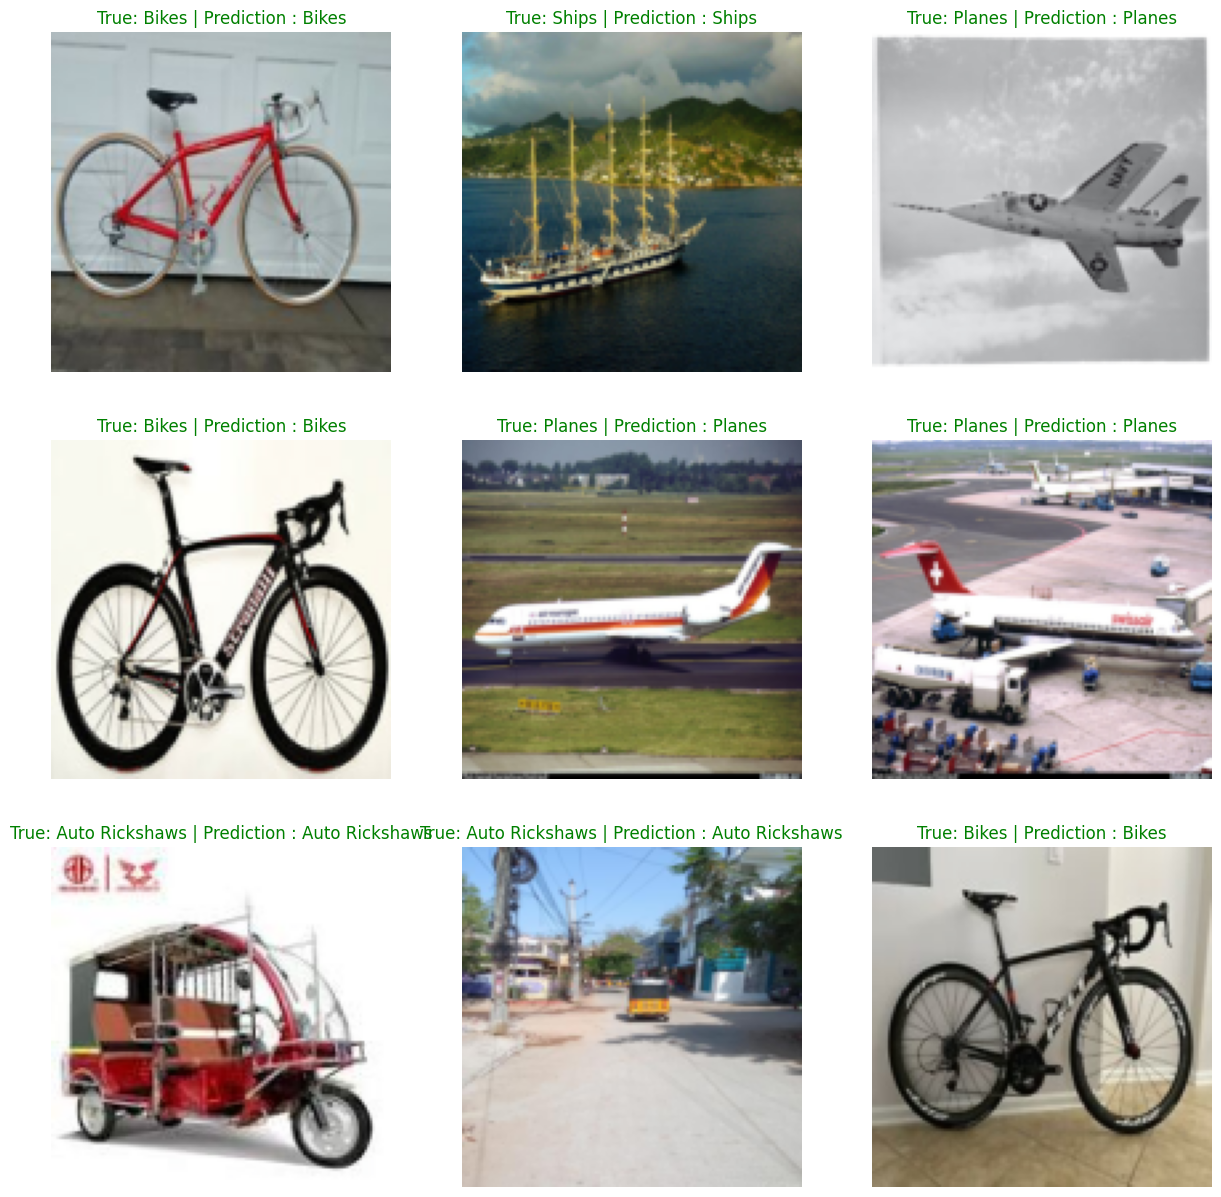

In [ ]:
#Visualising Grid
torch.manual_seed(manual_seed)

fig = plt.figure(figsize = (15, 15))
rows, cols = 3, 3

mean = [0.4641, 0.4725, 0.4705]
std = [0.3169, 0.3097, 0.3201]

inverse_test_transform = transforms.Compose([
    transforms.Normalize(
        mean = [-m / s for m , s in zip(mean, std)],
        std = [1/s for s in std]
    )
])

DriveMind.eval()

with torch.no_grad():
    for i in range(1, rows * cols + 1):
        fig.add_subplot(rows, cols, i)
        idx = torch.randint(0, len(test_dataset), size = [1]).item()
        img, label = test_dataset[idx]

        img = img.unsqueeze(0).to(device)
        logits = DriveMind(img)
        preds = torch.argmax(logits, dim = 1)

        img = inverse_test_transform(img)

        #Image is in [C, H ,W]
        img = img.squeeze().permute(1, 2, 0).to('cpu')
        label = test_dataset.classes[label]
        preds = test_dataset.classes[preds]

        if label == preds:
            color = 'green'
        else:
            color = 'red'

        plt.title(f"True: {label} | Prediction : {preds}", color = color)
        plt.imshow(img)
        plt.axis(False)

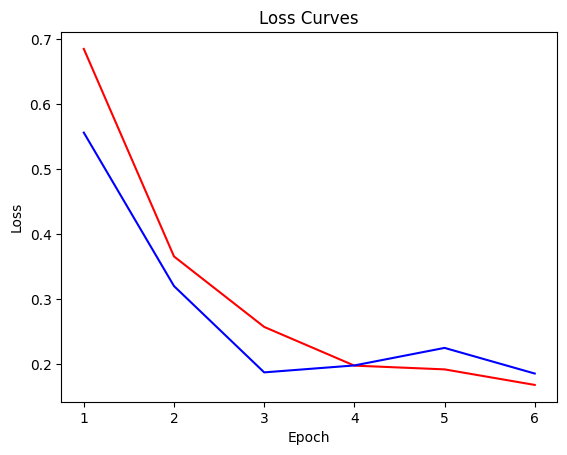

In [ ]:
train_loss = train_loss_list
validation_loss = validation_loss_list
epochs = list(range(1, len(train_loss_list) + 1))

plt.plot(epochs, train_loss, color = "red")
plt.plot(epochs, validation_loss, color = "blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.show()

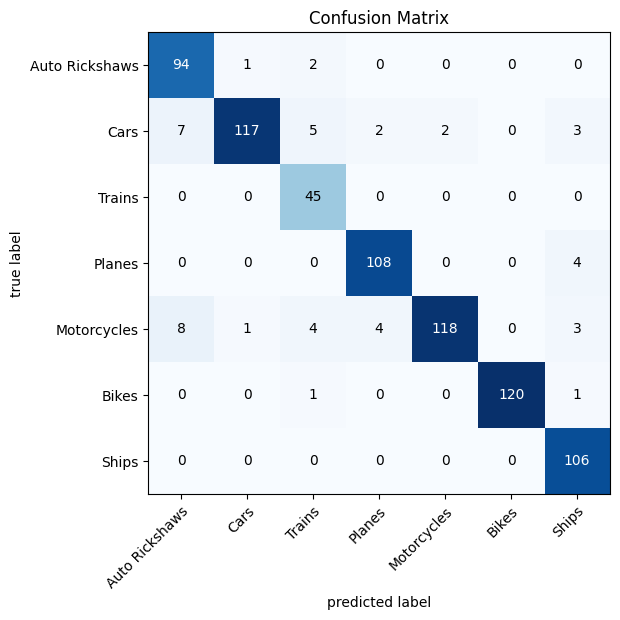

In [ ]:
#Confusion Matrix
confmat = ConfusionMatrix(num_classes = len(test_dataset.classes),
                         task = "multiclass").to(device)
DriveMind.eval()

test_loss, test_accuracy = 0, 0
DriveMind.to(device)

with torch.inference_mode():
    for (X, y) in test_dataloader:
        X, y = X.to(device), y.to(device)

        yLogits = DriveMind(X)
        yPreds = torch.argmax(yLogits, dim = 1)

        confmat.update(y, yPreds)

cf = confmat.compute().cpu().numpy()

fig, ax = plot_confusion_matrix(conf_mat = cf,
                                figsize = (6, 6),
                                class_names = train_dataset.classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
save_model(
    folder = "/kaggle/working/",
    file_name = "DriveMind.pth",
    model = DriveMind
)

In [ ]:
from PIL import Image

# Load the image
image_path = '/content/plane.png'
image = Image.open(image_path).convert('RGB')

# Apply the validation/test transformation
# This includes resizing and normalization
processed_image = validation_transform(image)

# Add a batch dimension and move to the correct device
processed_image = processed_image.unsqueeze(0).to(device)

# Set the model to evaluation mode
DriveMind.eval()

# Perform inference
with torch.no_grad():
    logits = DriveMind(processed_image)
    preds = torch.argmax(logits, dim=1)

# Get the predicted class name
predicted_class = test_dataset.classes[preds.item()]

print(f"The predicted class for the image is: {predicted_class}")

The predicted class for the image is: Planes


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
